In [1]:
# calculate avg error given an output file

In [ ]:
import numpy as np

In [2]:
filename = 'test_1var_simple_mesh_GPT2.out'

In [26]:
testCaseTemplate = 'Test case {}/{}'
resultDict = {}

with open(filename, 'r') as f:
    lines = f.readlines()
    for line in lines:
        #print(line)
        if 'Test case' in line:
            st = line.split('Test case ')[1].strip('.')
            idx, _ = st.split('/') 
            idx = eval(idx)
        elif ':' in line:
            modelName, err = line.split(': ')
            err = err.strip('\n')
            err = eval(err)
            
            if modelName in resultDict.keys():
                resultDict[modelName].append(err)
            else:
                resultDict[modelName] = [err]

In [48]:
# if there is a data.json with resultDict
# laod the file
import json
with open('./data.json', 'r', encoding="utf-8") as h:
    resultDict = json.load(h)
resultDict = resultDict['D:/Datasets/Symbolic Dataset/Datasets/Mesh_Simple_GPT2/TestDataset\\Test.json']

In [49]:
for key in resultDict:
    print('{} avg err is {}'.format(key,np.mean(resultDict[key])))

GPT2 avg err is 948.3124101553235
MLP avg err is 639.2887139854412
GP avg err is 785.4785784061652


Text(0, 0.5, 'Frequency Percentage')

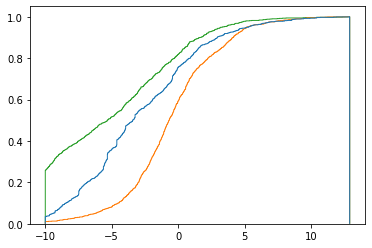

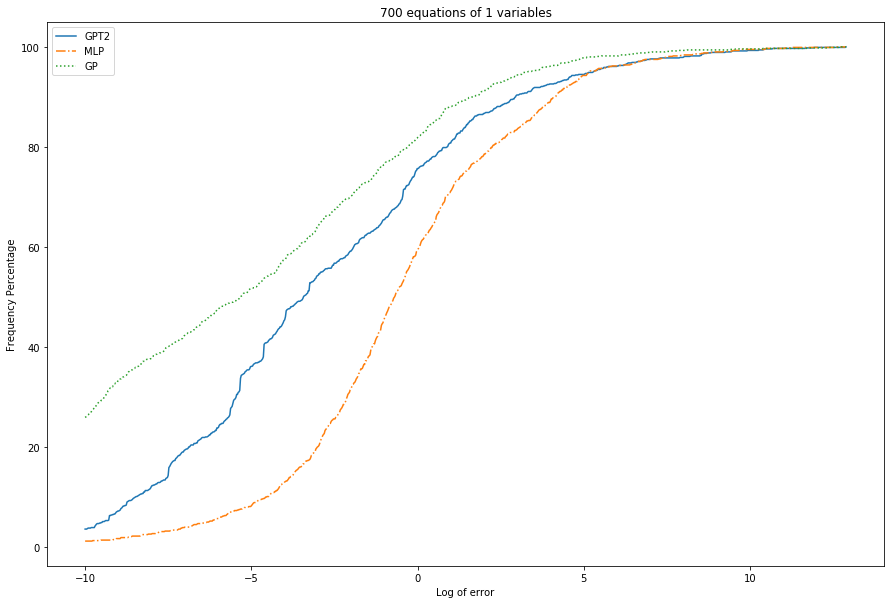

In [50]:
# plot the error frequency for model comparison
from matplotlib import pyplot as plt
num_eqns = 700
num_vars = 1

models = list(resultDict.keys())
lists_of_error_scores = [resultDict[key] for key in models]
linestyles = ["-","dashdot","dotted","--"]

y, x, _ = plt.hist([np.log(e) for e in lists_of_error_scores],
                   label=models,
                   cumulative=True, 
                   histtype="step", 
                   bins=1000, 
                   density="true")
plt.figure(figsize=(15, 10))

for idx, model in enumerate(models): 
  plt.plot(x[:-1], 
           y[idx] * 100, 
           linestyle=linestyles[idx], 
           label=model)

plt.legend(loc="upper left")
plt.title("{} equations of {} variables".format(num_eqns, num_vars))
plt.xlabel("Log of error")
plt.ylabel("Frequency Percentage")